1) Use FAO FAUL: Level 1 or Level 2
2) Follow the Pipeline

In [1]:
# Enter your own export to assets path name here -----------
EXPORT_PATH = 'projects/satvis-425514/assets/imad'
# ------------------------------------------------

In [2]:
import ee

ee.Authenticate(auth_mode='notebook')
ee.Initialize(project='satvis-425514')

In [3]:
# Import other packages used in the tutorial
%matplotlib inline
import geemap
import numpy as np
import random, time
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

from pprint import pprint  # for pretty printing


In [4]:
%run mad_shared.ipynb

# Generate the Dataset

### Define the aoi

In [95]:
lon = 45.65
lat = 25.5         
             
visbands = ['B2', 'B3', 'B4']    
visirbands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'] 

aoi = ee.FeatureCollection('FAO/GAUL/2015/level1') \
            .filter(ee.Filter.eq('ADM0_NAME', 'Romania')) \
            .filter(ee.Filter.eq('ADM1_NAME', 'Brasov')).geometry()   

# Initialize the map
M1 = geemap.Map()
M1.centerObject(aoi, 7)
M1.addLayer(aoi, {'color': 'blue'}, 'GAUL Level 1')

M1

Map(center=[45.78981328600311, 25.32964596667836], controls=(WidgetControl(options=['position', 'transparent_b…

In [99]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

# Collect a Sentinel-2 image pair.
def collect(aoi, t1a ,t1b, t2a, t2b):
    try:
        im1 = ee.Image( ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                            .filterBounds(aoi)
                            .filterDate(ee.Date(t1a), ee.Date(t1b))
                            # Pre-filter to get less cloudy granules.
                            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                            .map(mask_s2_clouds)
                            .mean()
                            .clip(aoi) )
        im2 = ee.Image( ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                            .filterBounds(aoi)
                            .filterDate(ee.Date(t2a), ee.Date(t2b))
                            # Pre-filter to get less cloudy granules.
                            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                            .map(mask_s2_clouds)
                            .mean()
                            .clip(aoi) )
        return (im1, im2)
    except Exception as e:
        print('Error: %s'%e)
        
        


### Collect Images

In [100]:
im1, im2 = collect(aoi, '2022-04-01', '2022-04-30', '2023-06-01', '2023-06-30')

M2 = geemap.Map()
M2.set_center(lat, lon, 12)
display_ls(im1.select(visbands), M2, 'im1') 
display_ls(im2.select(visbands), M2, 'im2') 
M2

Map(center=[45.65, 25.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

# iMAD Analysis

In [101]:
asset_path = f'{EXPORT_PATH}Brasov22-23'
run_imad(aoi, im1.select(visirbands), im2.select(visirbands), asset_path)

Exporting iMAD to projects/satvis-425514/assets/imadBrasov20-23
 task id: CSHOYTXIS4VKHRPJA4GZBZUG


In [108]:
ee.data.getTaskList()

[{'state': 'COMPLETED',
  'description': 'assetExportTask',
  'priority': 100,
  'creation_timestamp_ms': 1720353796396,
  'update_timestamp_ms': 1720366046466,
  'start_timestamp_ms': 1720360475217,
  'task_type': 'EXPORT_IMAGE',
  'destination_uris': ['https://code.earthengine.google.com/?asset=projects/satvis-425514/assets/imadBrasov20-23'],
  'attempt': 2,
  'batch_eecu_usage_seconds': 576522.6875,
  'id': 'CSHOYTXIS4VKHRPJA4GZBZUG',
  'name': 'projects/satvis-425514/operations/CSHOYTXIS4VKHRPJA4GZBZUG'},
 {'state': 'COMPLETED',
  'description': 'assetExportTask',
  'priority': 100,
  'creation_timestamp_ms': 1720193092618,
  'update_timestamp_ms': 1720195239607,
  'start_timestamp_ms': 1720193099110,
  'task_type': 'EXPORT_IMAGE',
  'destination_uris': ['https://code.earthengine.google.com/?asset=projects/satvis-425514/assets/imadLandkreisOlpeRedEdged'],
  'attempt': 1,
  'batch_eecu_usage_seconds': 13916.8935546875,
  'id': 'QM7EPKVMPBQKTGF4ZCTNO56D',
  'name': 'projects/satvis-4

In [112]:
im_imad = ee.Image(
    f'{EXPORT_PATH}Brasov20-23').select(0, 1, 2, 3, 4, 5)
im_z = ee.Image(
    f'{EXPORT_PATH}Brasov20-23').select(6).rename('Z')
niter = im_imad.get('niter').getInfo()
rhos = ee.List(im_imad.get('rhos')).getInfo()
print('iteratons: %i'%niter)
print('canonical correlations: %s'%rhos)

iteratons: 71
canonical correlations: [0.9542997354391068,0.8932940066006204,0.8116868921742607,0.6709585989085419,0.5308711672925656,0.4290332082973984]


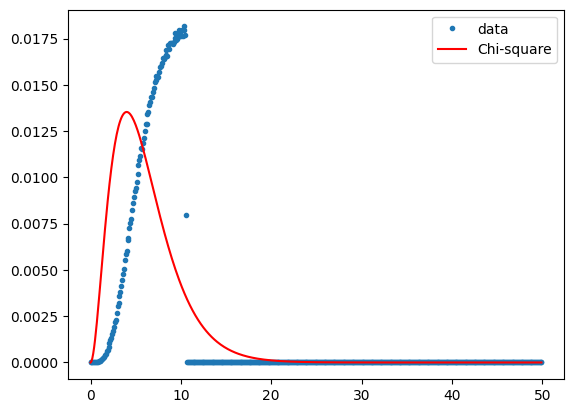

In [113]:
scale = 20
# p-values image
pval = chi2cdf(im_z, 6).subtract(1).multiply(-1).rename('pval') # 1 - CDF(x)
# No-change mask (use p-values greater than 0.1)
# any pixel with probability greater than 0.1 we assume to be no change
noChangeMask = pval.gt(0.1) 

hist = im_z.updateMask(noChangeMask).reduceRegion(ee.Reducer \
           .fixedHistogram(0, 50, 500), aoi, scale=scale, maxPixels=1e11).get('Z') \
           .getInfo()
a = np.array(hist)
x = a[:, 0]                     # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1])     # normalized array of buckets contents
plt.plot(x, y, '.', label='data')
# The chi-square distribution with 6 degrees of freedom.
plt.plot(x, chi2.pdf(x, 6)/10, '-r', label='Chi-square')
plt.legend()
plt.show()

In [116]:
M3 = geemap.Map()
M3.set_center(lat, lon, 12)
display_ls(im1.select(visbands), M3, 'im1') 
display_ls(im2.select(visbands), M3, 'im2') 
display_ls(im_imad.select('iMAD1', 'iMAD2', 'iMAD3'), M3, 'iMAD123', True)

M3

Map(center=[45.65, 25.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

# Clustering

In [123]:
# Standardize to no change sigmas.
sigma2s = ee.Image.constant([2*(1-x) for x in eval(rhos)])
im_imadstd = im_imad.divide(sigma2s.sqrt())
# Collect training data.
training = im_imadstd.sample(region=aoi, scale=scale, numPixels=50000)
# Train the clusterer.
clusterer = ee.Clusterer.wekaXMeans(6).train(training) 
result = im_imadstd.cluster(clusterer)

In [1]:
M4 = geemap.Map()
M4.centerObject(aoi, 13)
display_ls(im1.select(visbands), M4, 'im1')
display_ls(im2.select(visbands), M4, 'im2')
cluster0 = result.updateMask(result.eq(0))
cluster1 = result.updateMask(result.eq(1))
cluster2 = result.updateMask(result.eq(2))
cluster3 = result.updateMask(result.eq(3))
cluster4 = result.updateMask(result.eq(4))
cluster5 = result.updateMask(result.eq(5))
palette = ['red', 'yellow', 'blue', 'black', 'orange', 'pink']
vis_params = {'min': 0, 'max': 5, 'palette': palette}

M4.addLayer(cluster0, vis_params, 'snow')
M4.addLayer(cluster1, vis_params, 'clouds')
M4.addLayer(cluster2, vis_params, 'grass')
M4.addLayer(cluster3, vis_params, 'city, agriculture')
M4.addLayer(cluster4, vis_params, 'X')
M4.addLayer(cluster5, vis_params, 'Y')

M4

NameError: name 'geemap' is not defined